<a href="https://colab.research.google.com/github/evanphilipsmith/music-style-transfer/blob/main/music_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [1]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!pip install youtube_dl

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 59.9MB/s 
     |████████████████████████████████| 7.6MB 9.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 1.9MB 12.3MB/s 


## Imports

In [3]:
import pdb
import os
import gc
import io

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils, datasets

import torchaudio
torchaudio.set_audio_backend("sox_io")

import ipywidgets as widgets
from IPython.display import Audio, display
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Verbose', color_scheme='LightBg')

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Download Audio

In [4]:
def get_youtube_audio(link, song):
    !youtube-dl -x --audio-format wav -o "{song}.%(ext)s" {link} > /dev/null

get_youtube_audio('https://www.youtube.com/watch?v=_WS9w10ygpU', 'hello')
get_youtube_audio('https://www.youtube.com/watch?v=ZEcqHA7dbwM', 'fly')

## Audio Prep

In [5]:
#@title # Configuration { run: "auto", form-width: "40%" }

#@markdown Clip lengths
SHORT_CLIP_LENGTH = 15 #@param {type:"integer"}
LONG_CLIP_LENGTH = 60 #@param {type:"integer"}

#@markdown Clip length used during learning
SAMPLE_LENGTH = "short" #@param ["short", "long", "full"]

#@markdown Downsampling
DOWNSAMPLE = True #@param {type:"boolean"}
DOWNSAMPLED_SAMPLE_RATE = 16000 #@param {type:"integer"}

#@markdown Audio channels
MONO_AUDIO = True #@param {type:"boolean"}


class Song():
    def __init__(self, path, short_clip_start=0, long_clip_start=0):
        self.waveform, self.sample_rate = torchaudio.load(path)
        self.short_clip = (short_clip_start, short_clip_start+SHORT_CLIP_LENGTH)
        self.long_clip = (long_clip_start, long_clip_start+LONG_CLIP_LENGTH)
        self.resampler = torchaudio.transforms.Resample(orig_freq=self.sample_rate, new_freq=DOWNSAMPLED_SAMPLE_RATE)
    
    @staticmethod
    def monoify(input):
        return torch.mean(input, dim=0, keepdim=True)
    
    def clip(self, start, end):
        return self.waveform[:, start*self.sample_rate:end*self.sample_rate]
    
    def get_waveform(self, length=SAMPLE_LENGTH, downsample=DOWNSAMPLE, mono=MONO_AUDIO):
        if length == 'short':
            result = self.clip(*self.short_clip)
        elif length == 'long':
            result = self.clip(*self.long_clip)
        elif length == 'full':
            result = self.waveform
        else:
            raise NotImplementedError()
        
        if downsample:
            result = self.resampler(result)
        
        if mono:
            result = self.monoify(result)
                
        return result
    
    def get_sample_rate(self):
        return DOWNSAMPLED_SAMPLE_RATE if DOWNSAMPLE else self.sample_rate


#@markdown -----
#@markdown # Select a content file
content_file = "fly.wav" #@param {type:"string"}
short_clip_start = 7 #@param {type:"integer"}
long_clip_start = 0 #@param {type:"integer"}

content_song = Song(content_file, short_clip_start, long_clip_start)

#@markdown -----
#@markdown # Select a style file
style_file = "hello.wav" #@param {type:"string"}
short_clip_start = 65 #@param {type:"integer"}
long_clip_start = 30 #@param {type:"integer"}

style_song = Song(style_file, short_clip_start, long_clip_start)

## Preview Songs

In [6]:
#@title Preview Content Song { run: "auto", vertical-output: true }
sample_length = "short" #@param ["short", "long", "full"]
preview_downsampled = True #@param {type:"boolean"}
preview_mono = True #@param {type:"boolean"}

waveform = content_song.get_waveform(length=sample_length, downsample=preview_downsampled, mono=preview_mono)
rate = content_song.get_sample_rate()

print(f'File: {content_file}, sample length: {sample_length}, sample rate: {rate}, {"mono" if preview_mono else "stereo"}')
display(Audio(waveform, rate=rate))

File: fly.wav, sample length: short, sample rate: 16000, mono


In [7]:
#@title Preview Style Song { run: "auto", vertical-output: true }
sample_length = "short" #@param ["short", "long", "full"]
preview_downsampled = True #@param {type:"boolean"}
preview_mono = True #@param {type:"boolean"}

waveform = style_song.get_waveform(length=sample_length, downsample=preview_downsampled, mono=preview_mono)
rate = style_song.get_sample_rate()

print(f'File: {style_file}, sample length: {sample_length}, sample rate: {rate}, {"mono" if preview_mono else "stereo"}')
display(Audio(waveform, rate=rate))

File: hello.wav, sample length: short, sample rate: 16000, mono


## Extract Features

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    @staticmethod
    def gram_matrix(input):
        a, b, c, d = input.size() # where a=batch size (always 1 here)
        # b=number of feature maps
        # (c,d)=dimensions of a feature map (N=c*d)

        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())

        # normalize the values of the gram matrix by dividing by the number of
        # elements in each feature map
        return G.div(a * b * c * d)
    
    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
class CustomVGG(nn.Module):
    def __init__(self, content_img, style_img, content_layers, style_layers, device):
        super(CustomVGG, self).__init__()
        vgg = torchvision.models.vgg19(pretrained=True).features.to(device).eval()
        vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)
        normalization = transforms.Normalize(vgg_normalization_mean, vgg_normalization_std).to(device)
        self.model = nn.Sequential(normalization)
        self.content_losses, self.style_losses = [], []

        i, j = 1, 1
        # vgg = copy.deepcopy(vgg)
        for layer in vgg.children():
            if isinstance(layer, nn.Conv2d):
                name = f'conv{i}_{j}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu{i}_{j}'
                j += 1
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool{i}'
                i += 1
                j = 1
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn{i}'
            else:
                raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')
            
            self.model.add_module(name, layer)

            if name in content_layers:
                target = self.model(content_img).detach()
                content_loss = ContentLoss(target)
                self.model.add_module(f'content_loss{i}', content_loss)
                self.content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = self.model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                self.model.add_module(f'style_loss{i}', style_loss)
                self.style_losses.append(style_loss)
        
        # now we trim off the layers after the last content and style losses
        for i in range(len(self.model) - 1, -1, -1):
            if isinstance(self.model[i], ContentLoss) or isinstance(self.model[i], StyleLoss):
                break

        self.model = self.model[:(i + 1)]
    
    def forward(self, input):
        self.model(input)

In [10]:
#@title VGG-19 Customizer { run: "auto" }

#@markdown Possible layers
#@markdown ```
#@markdown 'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1'
#@markdown 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2'
#@markdown 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3'
#@markdown 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4'
#@markdown 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
#@markdown ```

content_layers = ['conv1_1'] #@param {type:"raw"}
style_layers = ['conv1_1', 'conv2_1', 'conv3_3', 'conv4_3', 'conv5_3'] #@param {type:"raw"}
style_layer_weights = [1000, 100, 100, 1, 0.1] #@param {type:"raw"}


In [11]:
class Features():
    def __init__(self, content_song: Song, style_song: Song, n_fft=1600, win_length=800, hop_length=200):
        self.__dict__.update(locals())
        assert self.content_song.get_sample_rate() == self.style_song.get_sample_rate()
        self.sample_rate = self.content_song.get_sample_rate()
        self.make_spectrogram = torchaudio.transforms.Spectrogram(n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_length, normalized=False)
        self.make_waveform = torchaudio.transforms.GriffinLim(n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_length, n_iter=64)

        self.scale_min = min(self.make_spectrogram(self.content_song.get_waveform()).log2().min(),
                             self.make_spectrogram(self.style_song.get_waveform()).log2().min())
        self.scale_max = max(self.make_spectrogram(self.content_song.get_waveform()).log2().max(),
                             self.make_spectrogram(self.style_song.get_waveform()).log2().max())
    
    def get_content_feats(self):
        return self._get_feats(self.content_song)

    def get_style_feats(self):
        return self._get_feats(self.style_song)
    
    def _get_feats(self, song: Song):
        return self.scale_minmax(self.make_spectrogram(song.get_waveform()).log2())

    def scale_minmax(self, X):
        return (X - self.scale_min) / (self.scale_max - self.scale_min)

    def unscale(self, X):
        return X * (self.scale_max - self.scale_min) + self.scale_min

    @staticmethod
    def show(spectrogram, title):
        image = spectrogram.detach().cpu().clone()
        num_channels = image.shape[0]
        if num_channels > 1:
            fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(8, 5))
            for channel in range(num_channels):
                axes[channel].imshow(image[channel, :, :])
                axes[channel].set_title(f'{title}: channel {channel}')
            
            fig.tight_layout()
        else:
            image = image.squeeze(0)
            plt.imshow(image)
            plt.title(title)
        plt.pause(0.001)
    
    def make_player(self, spectrogram):
        display(Audio(self.make_waveform(torch.pow(2, self.unscale(spectrogram.detach().cpu()))), rate=self.sample_rate))

### Custom VGGish stuff

In [12]:
# content_song.get_waveform().squeeze(0).numpy()

array([0.00828181, 0.0111702 , 0.00697335, ..., 0.02860826, 0.02304825,
       0.0213913 ], dtype=float32)

In [13]:
# class CustomVGGish(nn.Module):
#     def __init__(self):
#         super(CustomVGGish, self).__init__()
#         self.vggish = torch.hub.load('harritaylor/torchvggish', 'vggish').eval()


In [ ]:
# sample_rate = 16000
# log_offset = 0.01
# stft_window_length_seconds = 0.025
# stft_hop_length_seconds = 0.010
# num_bands = 64
# num_mel_bins = num_bands
# mel_min_hz = 125
# mel_max_hz = 7500
# example_window_seconds = 0.96
# example_hop_seconds = 0.96

# # log_mel = mel_features.log_mel_spectrogram(
# #     data, audio_sample_rate=sample_rate, log_offset=log_offset,
# #     window_length_secs=stft_window_length_seconds,
# #     hop_length_secs=stft_hop_length_seconds, num_mel_bins=num_mel_bins,
# #     lower_edge_hertz=mel_min_hz, upper_edge_hertz=mel_max_hz
# # )

# mel = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=num_mel_bins, win_length=stft_window_length_seconds, hop_length=stft_hop_length_seconds, f_min=mel_min_hz, f_max=mel_max_hz)
# specgram = mel(content_song.get_waveform())


# # Frame features into examples.
# features_sample_rate = 1.0 / stft_hop_length_seconds
# example_window_length = int(round(example_window_seconds * features_sample_rate))
# example_hop_length = int(round(example_hop_seconds * features_sample_rate))
# log_mel_examples = mel_features.frame(log_mel, window_length=example_window_length, hop_length=example_hop_length)

# log_mel_examples = torch.tensor(log_mel_examples, requires_grad=True)[:, None, :, :].float()

In [ ]:
# def test_scope():
#     model = torch.hub.load('harritaylor/torchvggish', 'vggish', pretrained=True).features.eval()
#     output = model(content_song.get_waveform().squeeze(0))
#     print(output.shape)
#     for c in model.children():
#         print(type(c))
#         if isinstance(c, nn.ReLU):
#             print('yep')
#             c.inplace = False
#         print(c)

# test_scope()

## Run style transfer

In [24]:
def run_style_transfer(content_img, style_img, style_layer_weights, num_epochs=500, style_weight=1e6, content_weight=1, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not MONO_AUDIO:
        raise NotImplementedError('We are just duplicating mono channel to 3 channels')
    content_img = content_img.repeat(3, 1, 1).unsqueeze(0).to(device)
    style_img = style_img.repeat(3, 1, 1).unsqueeze(0).to(device)

    input_img = content_img.detach().clone().to(device)
    model = CustomVGG(content_img, style_img, content_layers, style_layers, device)

    optimizer = optim.Adam([input_img.requires_grad_()], lr=lr)

    bar = tqdm(total=num_epochs, desc='Running style transfer', position=0, leave=True)
    for epoch in range(num_epochs):
        input_img.data.clamp_(0, 1)
        
        optimizer.zero_grad()
        model(input_img)

        content_score = 0
        for l in model.content_losses:
            content_score = content_score + l.loss
        content_score = content_score * content_weight

        style_score = 0
        for i, l in enumerate(model.style_losses):
            style_score = style_score + (l.loss * style_layer_weights[i])
        style_score = style_score * style_weight

        loss = content_score + style_score
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            bar.set_description(f'Content Loss: {content_score.item():.3f}, Style Loss: {style_score.item():.3f}')
        bar.update()
    input_img.data.clamp_(0, 1)
    return torch.mean(input_img.squeeze(0), dim=0, keepdim=True)

In [16]:
# feats = Features(content_song, style_song, n_fft=2048, win_length=400, hop_length=100)
feats = Features(content_song, style_song)
content_spectrogram = feats.get_content_feats()
style_spectrogram = feats.get_style_feats()

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


# View Results

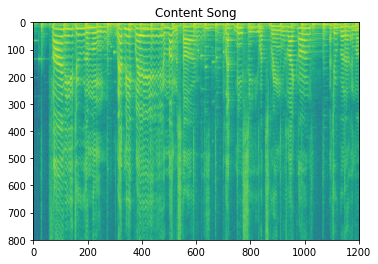

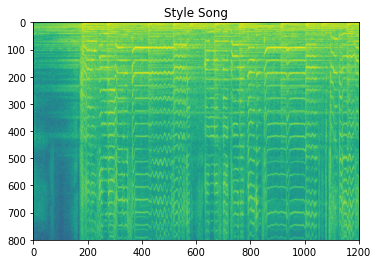

In [17]:
feats.show(content_spectrogram, 'Content Song')
feats.show(style_spectrogram, 'Style Song')

In [27]:
print('Content Song')
feats.make_player(content_spectrogram)
print('Style Song')
feats.make_player(style_spectrogram)

Content Song


Style Song


In [25]:
output_spectrogram = run_style_transfer(content_spectrogram, style_spectrogram, style_layer_weights, num_epochs=5000)

Content Loss: 0.175, Style Loss: 727.468: 100%|██████████| 5000/5000 [10:37<00:00,  7.82it/s]

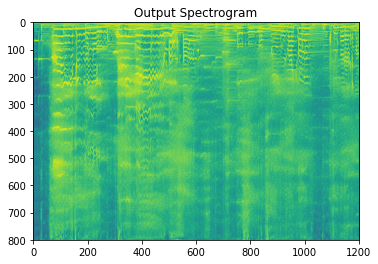

Output Song


In [28]:
feats.show(output_spectrogram, 'Output Spectrogram')
print('Output Song')
feats.make_player(output_spectrogram)